# Discrete Markov Chain Distribution

In [1]:
import numpy as np
import pymc as pm
import pytensor
import pytensor.tensor as pt
import arviz as az

import sys

sys.path.append("..")
from pymc_experimental.distributions.timeseries import DiscreteMarkovChain, _make_outputs_info

from pymc.distributions.shape_utils import (
    _change_dist_size,
    change_dist_size,
    get_support_shape_1d,
)

## Demonstration of API 

In [2]:
with pm.Model() as model:
    logit_P = pm.Normal("logit_P", sigma=0.1, size=(3, 3))
    discrete_mc = DiscreteMarkovChain("MarkovChain", logit_P=logit_P, steps=10)

C:\Users\Jesse\Python Projects\pymc-experimental\notebooks\..\pymc_experimental\distributions\timeseries.py:157: UserWarning: Initial distribution not specified, defaulting to `Categorical.dist(p=pt.full((k_states, ), 1/k_states), shape=...)`. You can specify an init_dist manually to suppress this warning.
  warnings.warn(


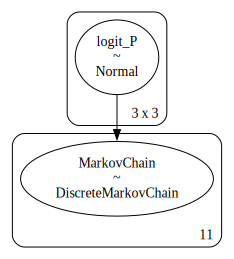

In [3]:
pm.model_to_graphviz(model)

Dims of the output are `(batch, time)`.

In [4]:
pm.draw(discrete_mc, 10)

array([[0, 2, 2, 2, 0, 0, 2, 2, 1, 1, 0],
       [0, 0, 0, 2, 0, 1, 0, 2, 2, 2, 1],
       [1, 0, 1, 0, 2, 2, 2, 2, 1, 2, 2],
       [2, 1, 0, 2, 2, 2, 2, 1, 2, 2, 1],
       [1, 1, 0, 1, 2, 0, 2, 2, 2, 2, 0],
       [2, 1, 0, 1, 0, 2, 0, 1, 1, 0, 0],
       [0, 1, 0, 1, 1, 1, 1, 2, 2, 0, 1],
       [2, 1, 2, 2, 2, 0, 0, 0, 2, 0, 2],
       [1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0],
       [0, 0, 0, 1, 2, 1, 2, 0, 2, 0, 1]], dtype=int64)

## Parameter Recovery

Estimate the transition matrix $P$ from data, using `DiscreteMarkovChain` as a likelihood

In [5]:
from scipy import stats

true_P = np.array([[0.6, 0.2, 0.2], [0.5, 0.1, 0.4], [0.1, 0.1, 0.8]])

x0_dist = stats.bernoulli(0.5)


def generate_chains(P, x0_dist, steps, n_chains=1):
    output = np.empty((n_chains, steps), dtype="int64")

    x0 = x0_dist.rvs(n_chains)
    output[:, 0] = x0

    for t in range(1, steps):
        output[:, t] = [
            np.random.choice(range(P.shape[0]), p=P[output[i, t - 1]].ravel()).astype(int)
            for i in range(n_chains)
        ]

    return output.squeeze()

In [6]:
chains = generate_chains(true_P, x0_dist, 100, n_chains=100)

In [7]:
with pm.Model() as model:
    x0 = pm.Categorical.dist(np.ones(3) / 3, size=(100,))
    P = pm.Dirichlet("P", a=[1, 1, 1], size=(3,))
    discrete_mc = DiscreteMarkovChain("MarkovChain", P=P, init_dist=x0, observed=chains)
    idata = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [P]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 35 seconds.


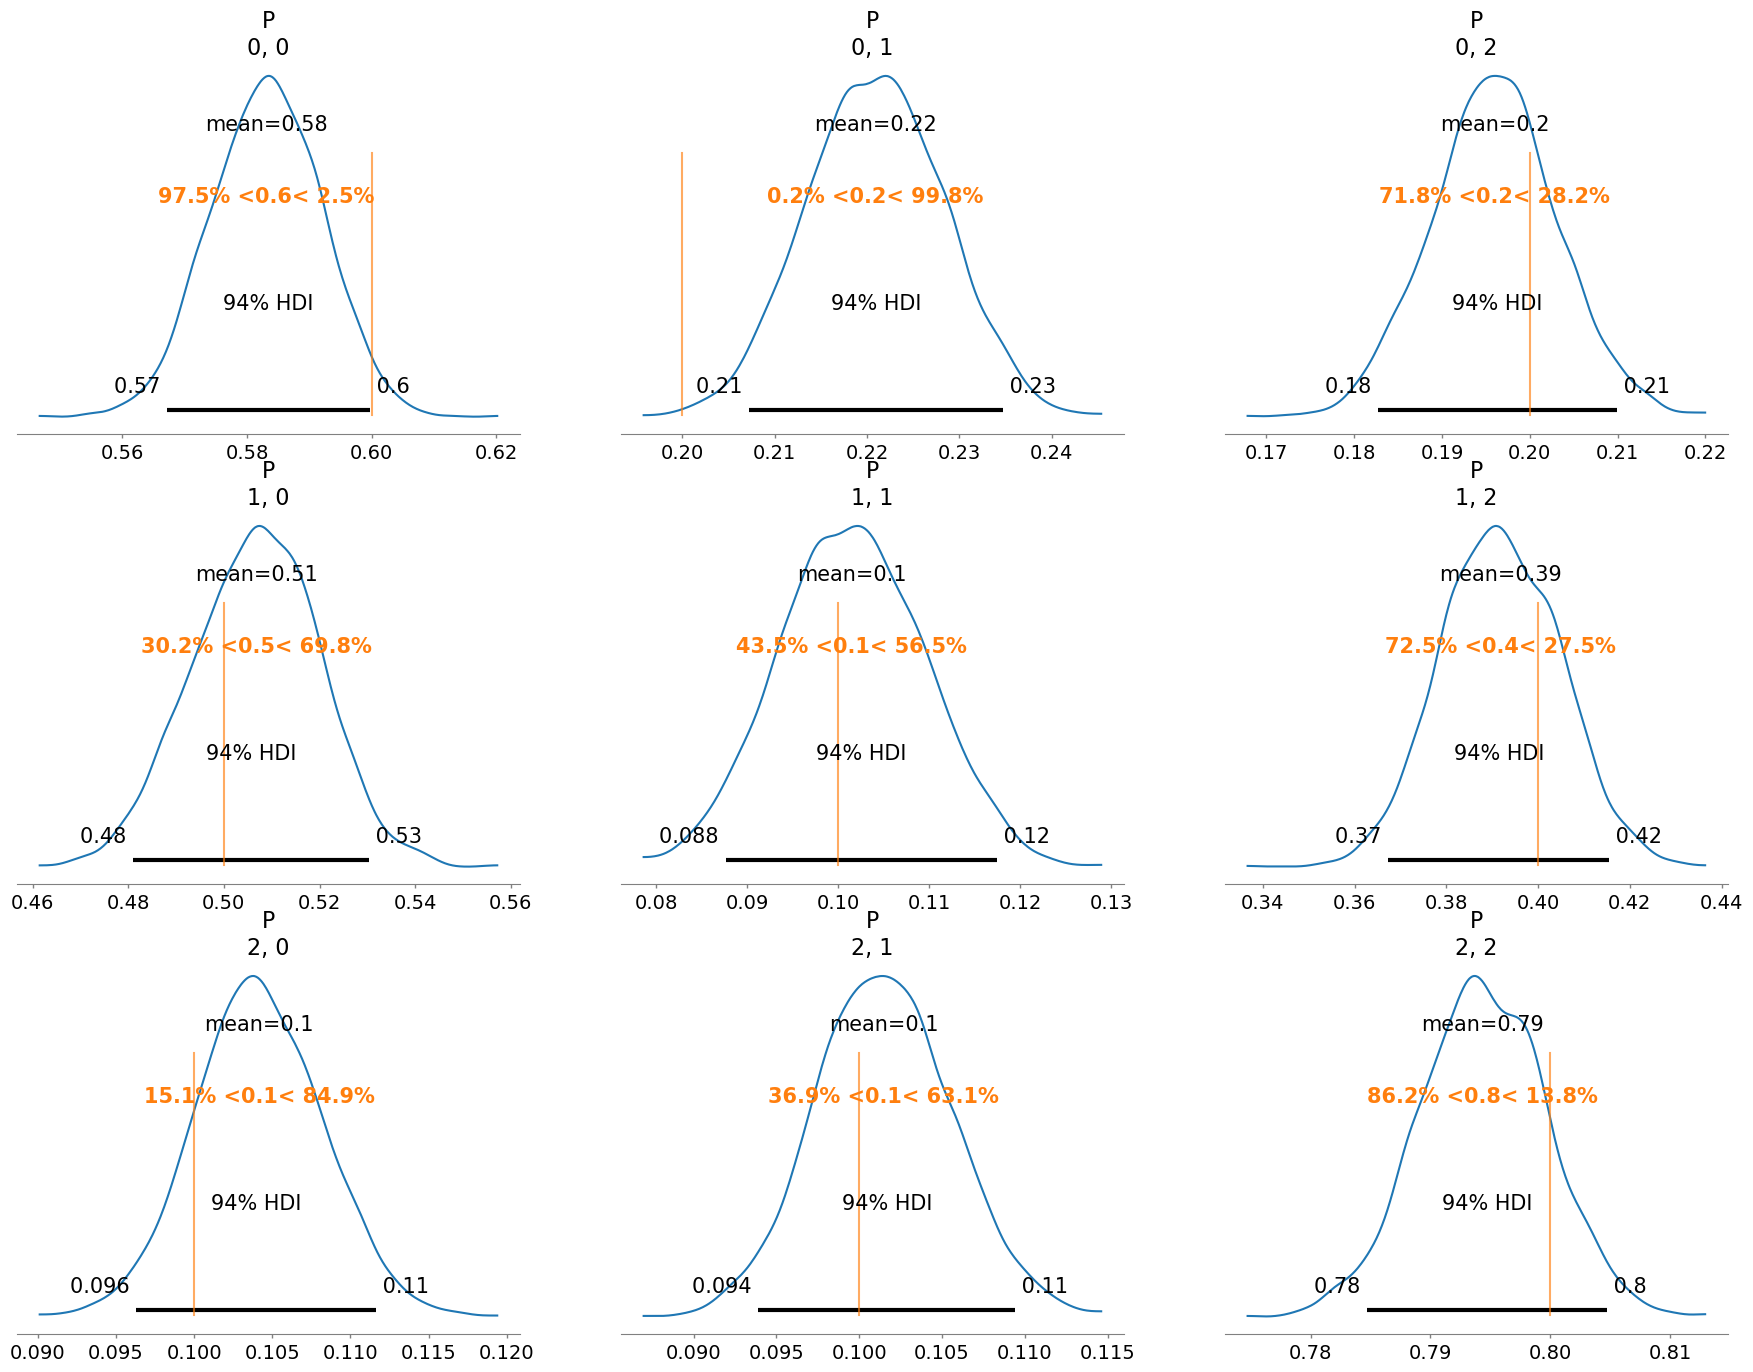

In [8]:
az.plot_posterior(idata, ref_val=true_P.ravel().tolist());

## Hidden markov model

Use `DiscreteMarkovChain` as a latent variable in a Hidden Markov Model. This example (along with data) is taken from the statsmodels documentation found here:

https://www.statsmodels.org/dev/examples/notebooks/generated/markov_autoregression.html

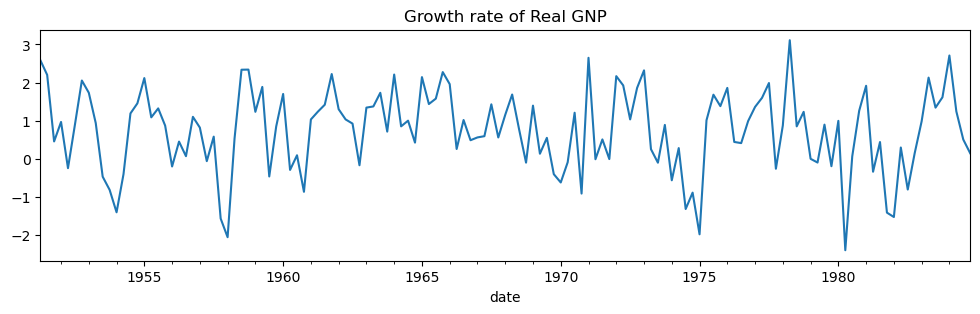

In [9]:
import pandas as pd
import statsmodels.api as sm

# Get the RGNP data to replicate Hamilton
dta = pd.read_stata("https://www.stata-press.com/data/r14/rgnp.dta").iloc[1:]
dta.index = pd.DatetimeIndex(dta.date, freq="QS")
dta_hamilton = dta.rgnp

# Plot the data
dta_hamilton.plot(title="Growth rate of Real GNP", figsize=(12, 3))

# Fit the model
mod_hamilton = sm.tsa.MarkovAutoregression(dta_hamilton, k_regimes=2, order=4, switching_ar=False)
res_hamilton = mod_hamilton.fit()

In [10]:
res_hamilton.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                         Markov Switching Model Results                         
================================================================================
Dep. Variable:                     rgnp   No. Observations:                  131
Model:             MarkovAutoregression   Log Likelihood                -181.263
Date:                  Mon, 17 Apr 2023   AIC                            380.527
Time:                          21:45:33   BIC                            406.404
Sample:                      04-01-1951   HQIC                           391.042
                           - 10-01-1984                                         
Covariance Type:                 approx                                         
                             Regime 0 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.3588      0.265     -1.356      0.175      -0.877       0.160
                             Regime 1 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.1635      0.075     15.614      0.000       1.017       1.310
                           Non-switching parameters                           
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.5914      0.103      5.761      0.000       0.390       0.793
ar.L1          0.0135      0.120      0.112      0.911      -0.222       0.249
ar.L2         -0.0575      0.138     -0.418      0.676      -0.327       0.212
ar.L3         -0.2470      0.107     -2.310      0.021      -0.457      -0.037
ar.L4         -0.2129      0.111     -1.926      0.054      -0.430       0.004
                         Regime transition parameters                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
p[0->0]        0.7547      0.097      7.819      0.000       0.565       0.944
p[1->0]        0.0959      0.038      2.542      0.011       0.022       0.170
==============================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
"""

In [11]:
T = dta_hamilton.shape[0]
order = 4

coords = {
    "dates": dta_hamilton.index,
    "obs_dates": dta_hamilton.index[order:],
    "states": ["State_1", "State_2"],
    "ar_params": [f"L{i+1}.phi" for i in range(order)],
}

with pm.Model(coords=coords) as hmm:
    y = pm.ConstantData("y", dta_hamilton, dims="dates")
    yobs = pm.ConstantData("yobs", dta_hamilton.iloc[4:], dims=["obs_dates"])

    # If there are only 2 states, Bernoulli is accepted as an init_dist
    s0 = pm.Bernoulli.dist(p=0.5)
    P = pm.Dirichlet("P", a=[1.0, 1.0], size=(2,))
    hidden_states = DiscreteMarkovChain(
        "hidden_states", P=P, init_dist=s0, steps=T - 1, dims=["dates"]
    )

    state_mus = pm.Normal(
        "state_mus",
        dims=["states"],
        transform=pm.distributions.transforms.univariate_ordered,
        initval=[-1, 1],
    )
    ar_coefs = pm.Normal("coefs", size=order, dims=["ar_params"])

    def AR_step(s, L1_s, L2_s, L3_s, L4_s, L1_y, L2_y, L3_y, L4_y, mus, phis):

        y_out = (
            mus[s]
            + phis[0] * (L1_y - mus[L1_s])
            + phis[1] * (L2_y - mus[L2_s])
            + phis[2] * (L3_y - mus[L3_s])
            + phis[3] * (L4_y - mus[L4_s])
        )

        return y_out

    result, updates = pytensor.scan(
        AR_step,
        sequences=[
            {"input": hidden_states, "taps": [0, -1, -2, -3, -4]},
            {"input": y, "taps": [-1, -2, -3, -4]},
        ],
        non_sequences=[state_mus, ar_coefs],
    )

    sigma = pm.HalfCauchy("sigma", 0.8)
    obs = pm.Normal("y_hat", mu=result, sigma=sigma, observed=yobs, dims=["obs_dates"])

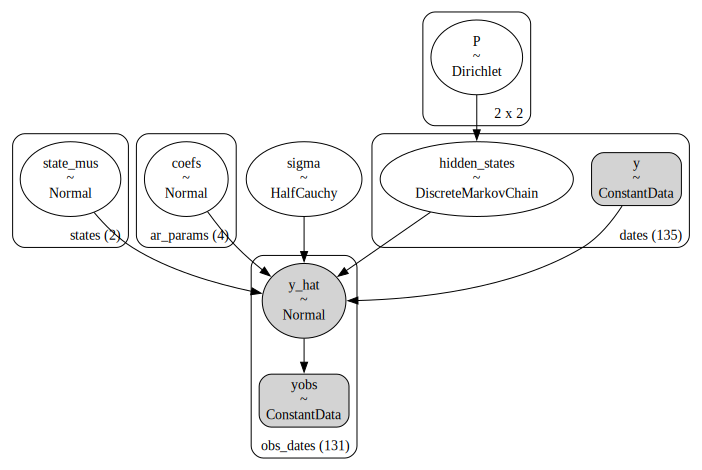

In [12]:
pm.model_to_graphviz(hmm)

It's quite difficult to sample this model, so I use a very high `target_accept` and a very large number of draws. It seems to be hard to get a sufficient number of effective samples for rare rates without a lot of draws. 

In [13]:
with hmm:
    # Need to assign BinaryMetropolis by hand, defaults to Metropolis and breaks.
    # BinaryGibbsMetropois seems to do much beter than BinaryMetropolis, but also much slower.
    idata = pm.sample(
        step=[
            pm.BinaryGibbsMetropolis([hidden_states]),
            pm.NUTS([P, state_mus, ar_coefs, sigma], target_accept=0.99),
        ],
        draws=5_000,
    )

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>BinaryGibbsMetropolis: [hidden_states]
>NUTS: [P, state_mus, coefs, sigma]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 1880 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


### Post-Estimation Diagnostics

Energy plot looks awful...

<Axes: >

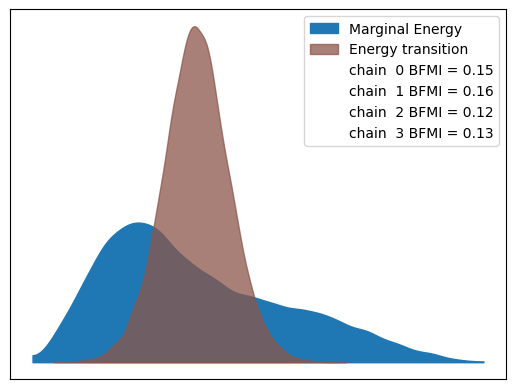

In [14]:
az.plot_energy(idata)

...but the trace plots look great! 

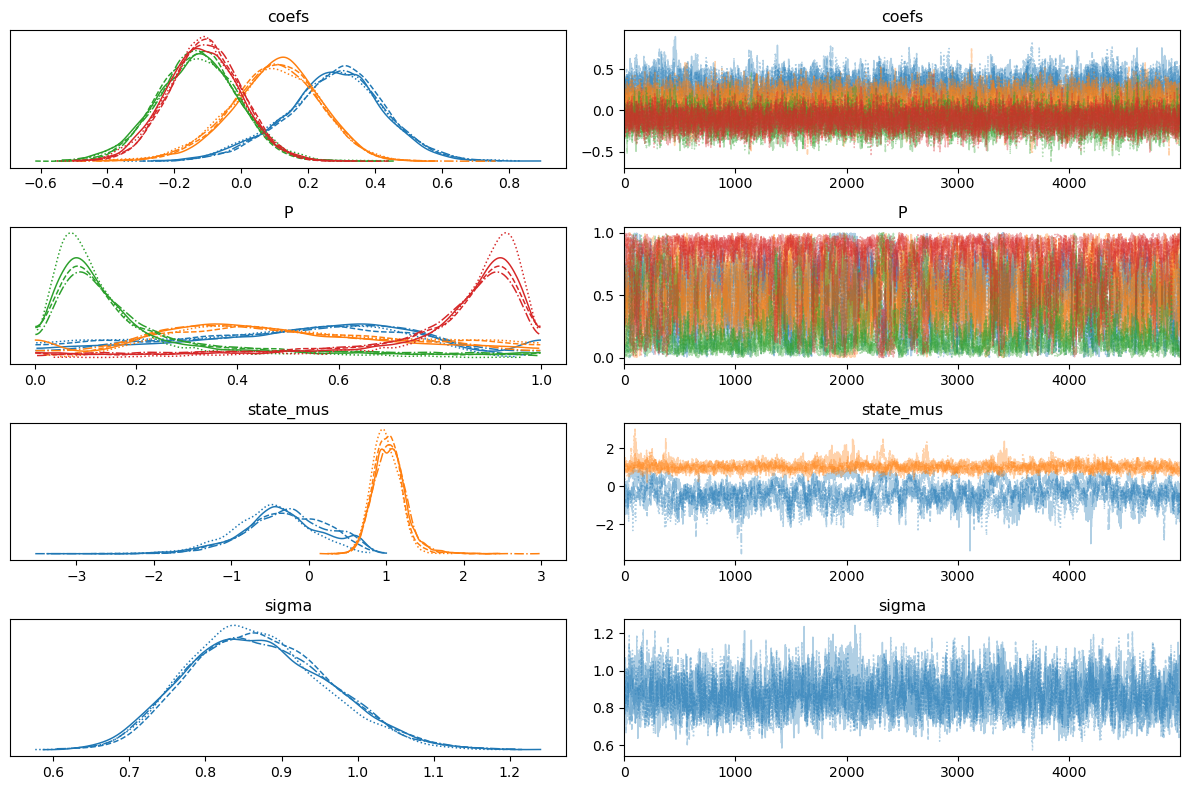

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt

az.plot_trace(idata, var_names=["~hidden_states"])
plt.tight_layout();

Even after 20,000 draws, we only have about 500 samples for the transition probabilities to the more rare state 1.

In [16]:
az.summary(idata, var_names=["~hidden_states"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
coefs[L1.phi],0.275,0.150,-0.019,0.555,0.006,0.004,598.0,1568.0,1.01
coefs[L2.phi],0.098,0.136,-0.155,0.354,0.003,0.002,1856.0,2556.0,1.00
coefs[L3.phi],-0.130,0.122,-0.359,0.097,0.003,0.002,2045.0,4296.0,1.00
coefs[L4.phi],-0.111,0.109,-0.320,0.092,0.002,0.002,2356.0,5668.0,1.00
"P[0, 0]",0.497,0.236,0.017,0.840,0.013,0.010,316.0,222.0,1.02
"P[0, 1]",0.503,0.236,0.160,0.983,0.013,0.009,316.0,222.0,1.02
"P[1, 0]",0.201,0.203,0.000,0.648,0.018,0.013,174.0,287.0,1.02
"P[1, 1]",0.799,0.203,0.352,1.000,0.018,0.013,174.0,287.0,1.02
state_mus[State_1],-0.351,0.538,-1.290,0.696,0.045,0.032,131.0,182.0,1.03
state_mus[State_2],1.025,0.203,0.663,1.385,0.009,0.007,564.0,478.0,1.01


## Comparison with Statsmodels

In [17]:
ref_vals = res_hamilton.params.copy()
ref_vals["p[0->1]"] = 1 - ref_vals["p[0->0]"]
ref_vals["p[1->1]"] = 1 - ref_vals["p[1->0]"]
ref_vals["sigma"] = np.sqrt(ref_vals["sigma2"])
ref_vals.drop("sigma2", inplace=True)
ref_vals.sort_index(inplace=True)

array([[<Axes: title={'center': 'coefs\nL1.phi'}>,
        <Axes: title={'center': 'coefs\nL2.phi'}>,
        <Axes: title={'center': 'coefs\nL3.phi'}>],
       [<Axes: title={'center': 'coefs\nL4.phi'}>,
        <Axes: title={'center': 'state_mus\nState_1'}>,
        <Axes: title={'center': 'state_mus\nState_2'}>],
       [<Axes: title={'center': 'P\n0, 0'}>,
        <Axes: title={'center': 'P\n0, 1'}>,
        <Axes: title={'center': 'P\n1, 0'}>],
       [<Axes: title={'center': 'P\n1, 1'}>,
        <Axes: title={'center': 'sigma'}>, <Axes: >]], dtype=object)

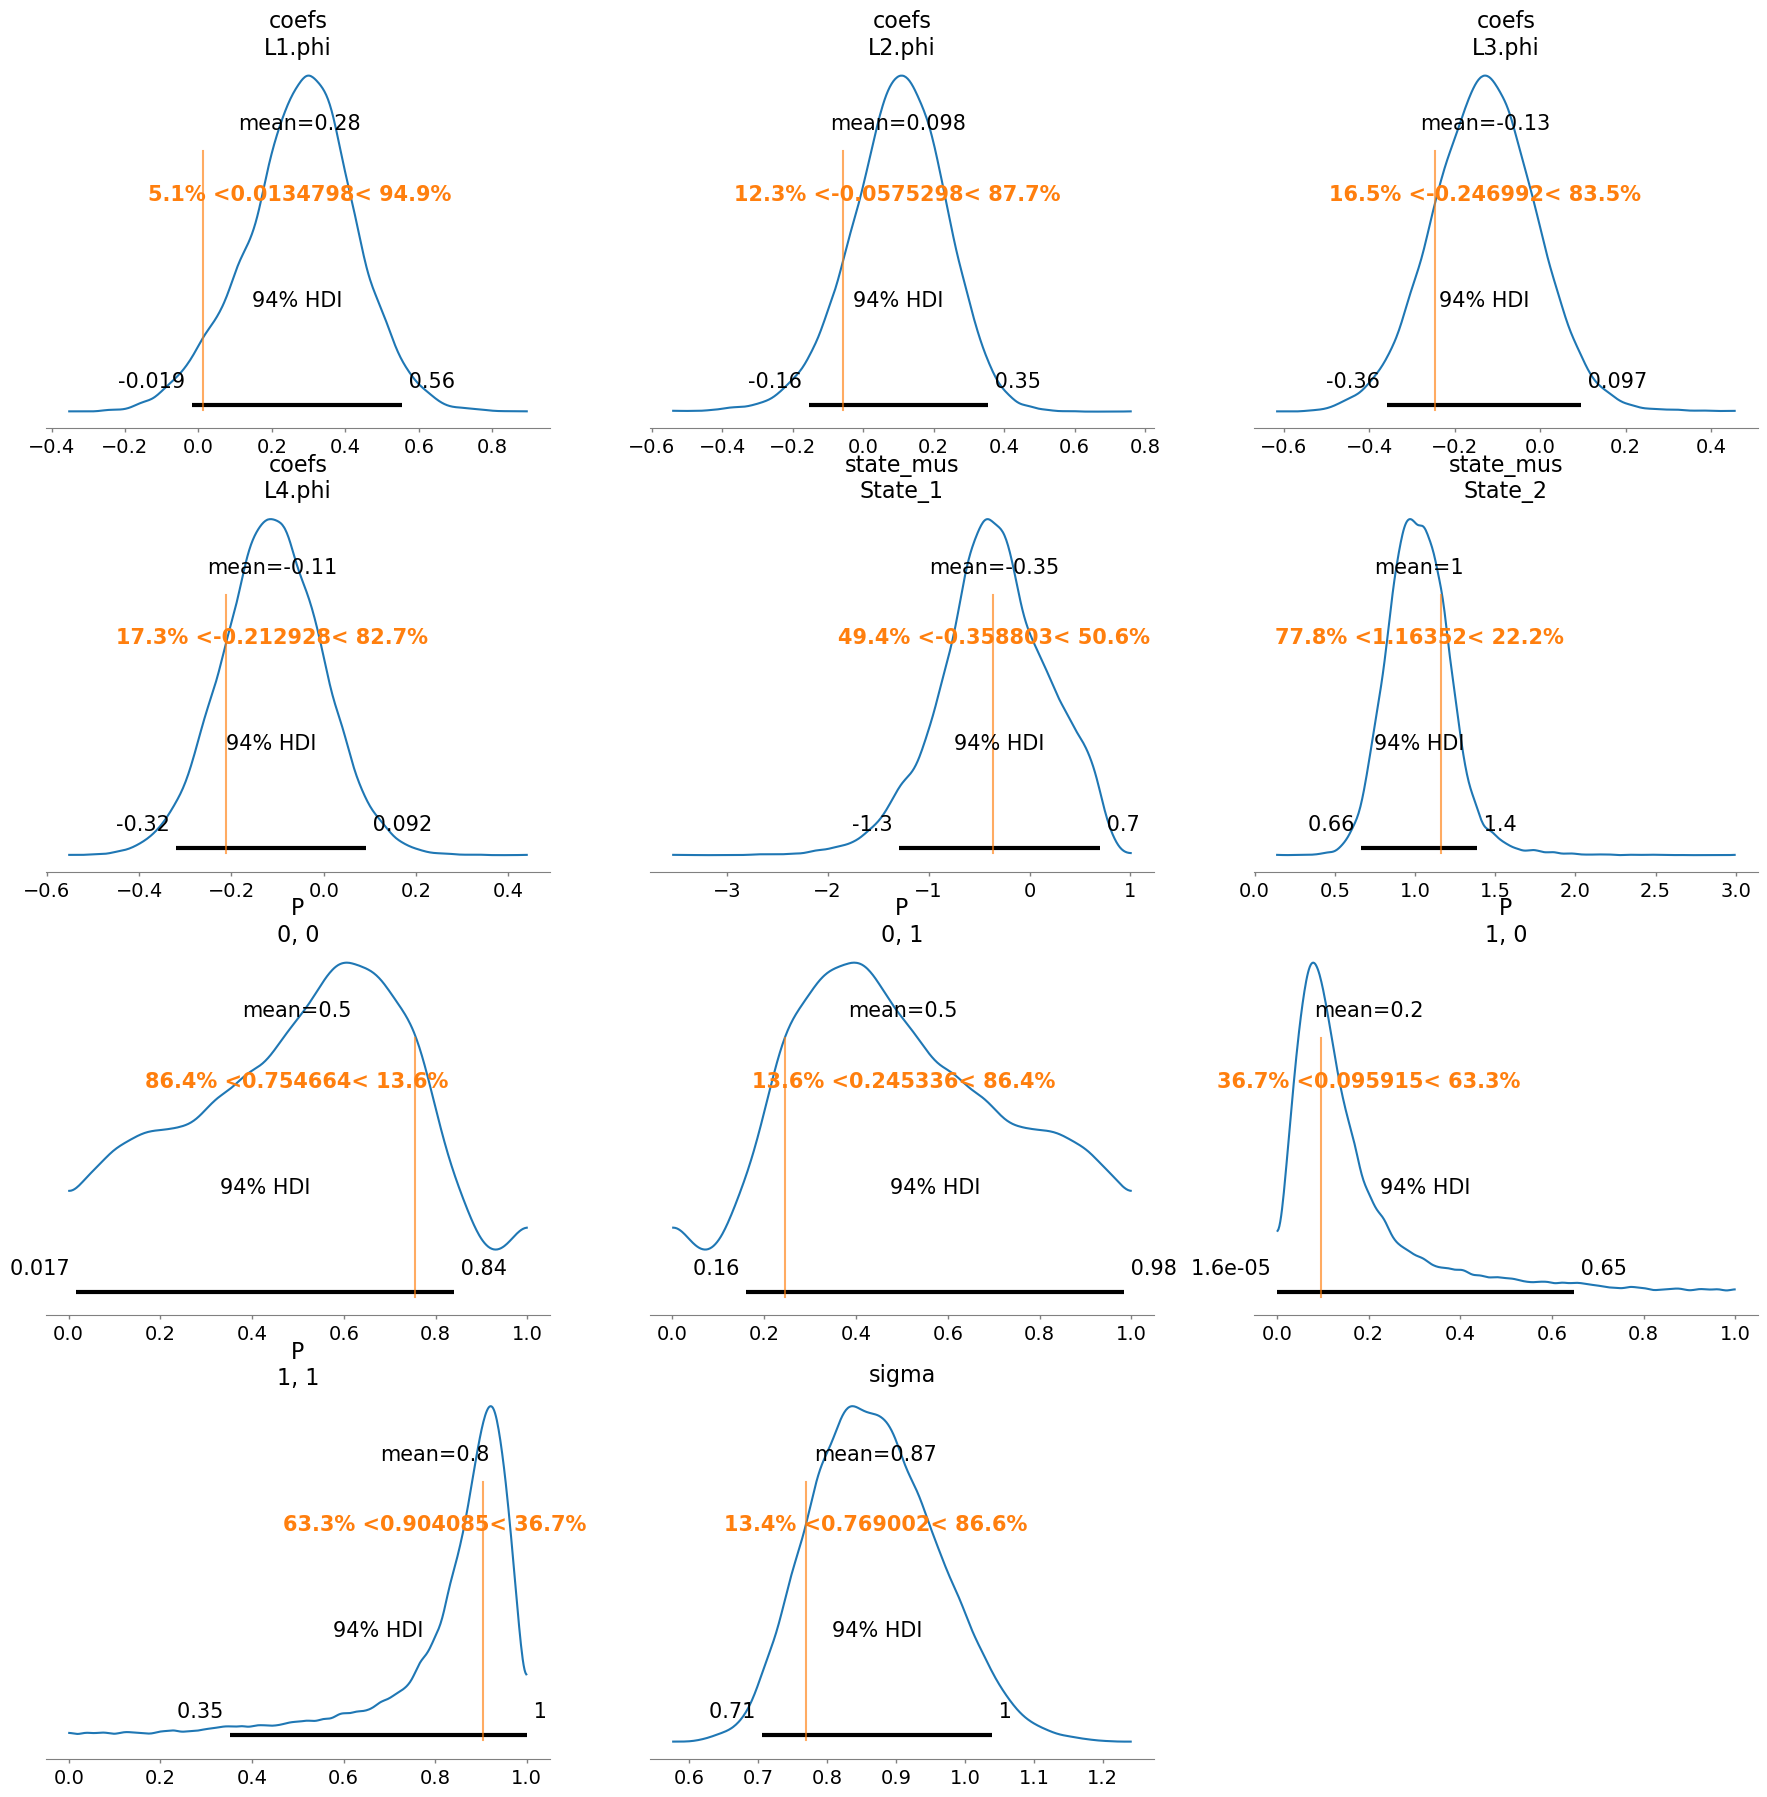

In [18]:
az.plot_posterior(
    idata, var_names=["coefs", "state_mus", "P", "sigma"], ref_val=ref_vals.values.tolist()
)

## Posterior Prediction

In [19]:
with hmm:
    idata = pm.sample_posterior_predictive(idata, extend_inferencedata=True)

Sampling: [y_hat]


In [20]:
post_pred = az.extract(idata, "posterior_predictive").y_hat
post = az.extract(idata)

mu = post_pred.mean("sample")
ci05, ci95 = post_pred.quantile([0.05, 0.95], dim="sample")

In [21]:
sm_preds = res_hamilton.predict()

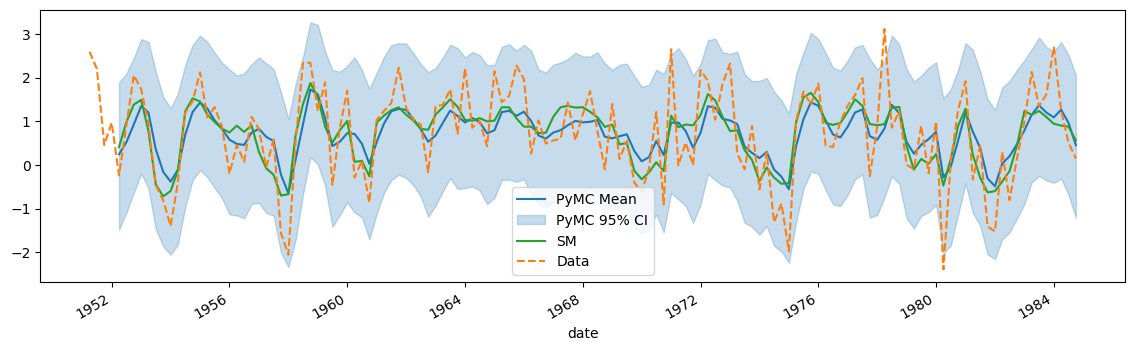

In [22]:
fig, ax = plt.subplots(figsize=(14, 4))
ax.plot(mu.coords["obs_dates"], mu, label="PyMC Mean")
ax.fill_between(
    mu.coords["obs_dates"], ci05, ci95, alpha=0.25, color="tab:blue", label="PyMC 95% CI"
)

ax.plot(sm_preds, color="tab:green", label="SM")
dta_hamilton.plot(ax=ax, ls="--", color="tab:orange", label="Data")

ax.legend()
plt.show()

## Regime Inference

We can consider the probability of seeing a certain state as the fraction of posterior draws corresponding to that state

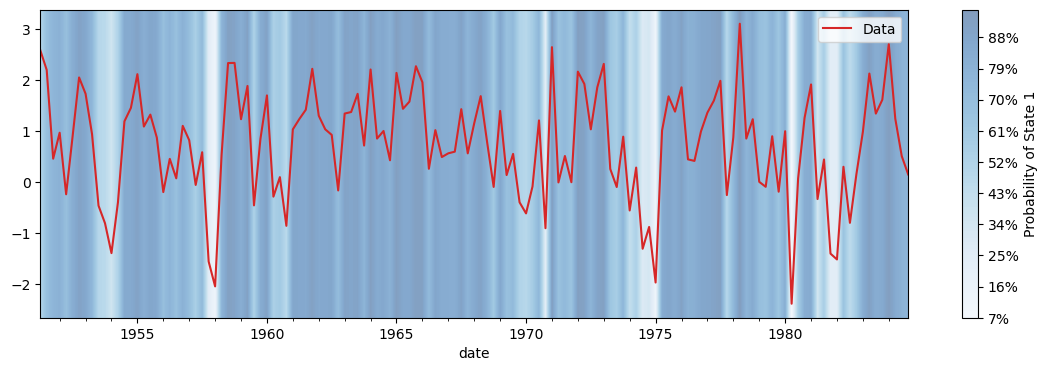

In [23]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import ticker as mtick

fig, ax = plt.subplots(figsize=(14, 4))
dta_hamilton.plot(ax=ax, color="tab:red", label="Data")

p_state_1 = post.hidden_states.mean(dim=["sample"])
ymin, ymax = ax.get_ylim()
y = np.linspace(ymin, ymax, T)
z, _ = np.meshgrid(p_state_1, p_state_1)

num_bars = 100
contour_plot = ax.contourf(dta_hamilton.index, y, z, num_bars, cmap="Blues", alpha=0.5, zorder=0)
contour_plot.set_clim(vmin=0, vmax=1)

cbar = fig.colorbar(
    contour_plot, ax=ax, label="Probability of State 1", format=mtick.PercentFormatter(xmax=1)
)

ax.legend()
plt.show()